In [1]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing the necessary packages
import pandas as pd
import numpy as np
import tensorflow as tf

In [3]:
#Dataset input read
df = pd.read_csv(r'/content/drive/MyDrive/FY_Project/OLIDv1.0/train_dataset.tsv',sep="\t") 

In [4]:
#Sample dataset
df.head(10)

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
5,97670,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH
6,77444,@USER @USER Oh noes! Tough shit.,OFF,UNT,NaN
7,52415,@USER was literally just talking about this lo...,OFF,TIN,GRP
8,45157,@USER Buy more icecream!!!,NOT,NaN,NaN
9,13384,@USER Canada doesn’t need another CUCK! We alr...,OFF,TIN,IND


In [5]:
#Shape of the dataset
df.shape

(13240, 5)

In [6]:
#Deleting the id as it adds no value in the model training
del df["id"]

In [7]:
#Installing the contractions library
!pip install contractions

     |████████████████████████████████| 327kB 5.1MB/s 
     |████████████████████████████████| 286kB 9.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85396 sha256=64b3182dd54f98a8e4c06f586c308604c6be1bf61be2845ed0175fdac2c5aac7
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [8]:
#importing required libraries
import json
import nltk
import inflect
from bs4 import BeautifulSoup
import contractions
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [9]:
# Downloading the necessary packages
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
# First function is used to denoise text
def denoise_text(text):
    # Strip html if any. For ex. removing <html>, <p> tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # Replace contractions in the text. For ex. didn't -> did not
    text = contractions.fix(text)
    return text

# Check the function 
sample_text = "<p>he didn't say anything </br> about what's gonna <html> happen in the climax"
denoise_text(sample_text)

'he did not say anything  about what is going to  happen in the climax'

In [11]:
# Text normalization includes many steps.
# Each function below serves a step.

In [12]:
# Gets rid of the non ASCII characters
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [13]:
# Converts the entire text to lowercase
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# Check the function 
sample_text = "He anyThing"
to_lowercase(sample_text)

['h', 'e', ' ', 'a', 'n', 'y', 't', 'h', 'i', 'n', 'g']

In [14]:
# Removes the punctuation marks
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Check the function 
sample_text = "He! anyThing?"
remove_punctuation(sample_text)

['H', 'e', ' ', 'a', 'n', 'y', 'T', 'h', 'i', 'n', 'g']

In [15]:
# Numbers to their textual representation
def replace_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

# Check the function 
sample_text = "0Hi 4 2 21"
replace_numbers(sample_text)

['zero', 'H', 'i', ' ', 'four', ' ', 'two', ' ', 'two', 'one']

In [16]:
#Using contractions dictionary to convert abbreviations into normal form. For Eg:lol converted into laughing out loud
abbreviations_path="/content/drive/MyDrive/FY_Project/abbreviations_wordlist.json"
abbreviations = json.load(open(abbreviations_path))
def contract_exp(words):
  new_words = []
  for word in words:
    if type(word) is str:
      for key in abbreviations:
        value = abbreviations[key]
        raw_text = r'\b' + key + r'\b'
        word = re.sub(raw_text, value, word)
    new_words.append(word)
  return new_words

In [17]:
# Removes stop words
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

In [18]:
# Lemmatizes verbs in the list of tokenized words
def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [19]:
#All above functions are put together
def normalize_text(words):
  
  words = remove_non_ascii(words)
  words = to_lowercase(words)
  words = remove_punctuation(words)
  words = replace_numbers(words)
  words = contract_exp(words)
  words = remove_stopwords(words)
  words = lemmatize_verbs(words)
  return words

In [20]:
# Tokenize tweet into words
def tokenize(text):
    return nltk.word_tokenize(text)
# check the function
sample_text = 'he did not say anything  about what is going to  happen'
print("tokenize results :", tokenize(sample_text))

tokenize results : ['he', 'did', 'not', 'say', 'anything', 'about', 'what', 'is', 'going', 'to', 'happen']


In [21]:
#text_prepare function
def text_prepare(text):
    text = denoise_text(text)
    text = ' '.join([x for x in normalize_text(tokenize(text))])
    return text
text_prepare("Hello world going patna ?!H 21 lol")


'hello world go patna h twenty-one laughing out loud'

In [22]:
#Text Preparation to use them into model
df['tweet'] = [text_prepare(x) for x in df['tweet']]

#Sample dataset after text_prepare
df.head()

,tweet,subtask_a,subtask_b,subtask_c
0,user ask native americans take,OFF,UNT,NaN
1,user user go home drink user maga trump2020 url,OFF,TIN,IND
2,amazon investigate chinese employees sell inte...,NOT,NaN,NaN
3,user someone shouldvetaken piece shit volcano,OFF,UNT,NaN
4,user user obama want liberals illegals move re...,NOT,NaN,NaN


In [23]:
#Creating Embedding dictionary for all the words present in twitter glove file
embeddings_dictionary = dict()
glove_file = open(r'/content/drive/MyDrive/FY_Project/glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [24]:
#Importing packages from Tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Level-1 classification starts here

In [25]:
#Class counts
df["subtask_a"].value_counts()

NOT    8840
OFF    4400
Name: subtask_a, dtype: int64

In [26]:
#dfa represents the tweets with offensive classification
dfa=df[df["subtask_a"]=="OFF"]
#dfb represents the tweets with not offensive classification
dfb=df[df["subtask_a"]=="NOT"]
dfb.head()

,tweet,subtask_a,subtask_b,subtask_c
2,amazon investigate chinese employees sell inte...,NOT,NaN,NaN
4,user user obama want liberals illegals move re...,NOT,NaN,NaN
8,user buy icecream,NOT,NaN,NaN
10,user user user fault support gun control,NOT,NaN,NaN
11,user difference kavanaugh user one men admit g...,NOT,NaN,NaN


In [27]:
#Upscaling
dfa=dfa.sample(n=int(0.9*dfb.shape[0]),random_state=2,replace=True)
df1=pd.concat([dfa,dfb],axis=0)
df1=df1.reset_index(drop=True)
df1.head()

,tweet,subtask_a,subtask_b,subtask_c
0,willie lose half fan get involve politics fan ...,OFF,TIN,IND
1,user user user user user user user user user u...,OFF,TIN,IND
2,user realize ridiculously radical tweet sound ...,OFF,TIN,IND
3,user see like lust girl long blond hair bare m...,OFF,TIN,IND
4,user hate politics cnn despicable liberals tre...,OFF,TIN,GRP


In [28]:
#Input dataset
X=df1['tweet']

In [29]:
#Class counts
df1["subtask_a"].value_counts()

NOT    8840
OFF    7956
Name: subtask_a, dtype: int64

In [30]:
#Y represents the class of the dataset
Y = df1["subtask_a"]
#0 represents NOT and 1 represents OFF
Y = (Y=="OFF").astype(int)
classes1=["NOT","OFF"]
#Class counts
(Y==0).sum(),(Y==1).sum()

(8840, 7956)

In [31]:
#Splitting the dataset into training and testing datasets resp. withe a ratio of 8:2
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((13436,), (13436,), (3360,), (3360,))

In [32]:
#No of instances with the classification class as "OFF"
(Y_train==1).sum()

6394

In [33]:
#Resetting the indices of the split datasets
X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)
Y_train=Y_train.reset_index(drop=True)

In [34]:
#X_test instances
X_test.head()

0    user ugh love gamecocks stay safe come home us...
1    user leveon bell dumbest argument compare coll...
2    user user leave become bunch thugs nancypelosi...
3    user white hot spotlight victim trump like abu...
4    user user user definitely feedback loop even w...
Name: tweet, dtype: object

In [35]:
#Corresponding Y_test instances
Y_test.head()

0    0
1    1
2    1
3    1
4    0
Name: subtask_a, dtype: int64

In [36]:
#Fitting tokenizer with training data
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(X_train)

#Texts converted to sequences
X_train_seq = tokenizer1.texts_to_sequences(X_train)
X_test_seq = tokenizer1.texts_to_sequences(X_test)

In [37]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer1.word_index) + 1

maxlen = 100

#Padding sequences to get same length sequences
X_train_padded = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test_padded = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

In [38]:
#Creating embedding matrix(vocabulory) for all the words in tokenizer
embedding_matrix = np.zeros((vocab_size, 200))
for word, index in tokenizer1.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [39]:
#Importing keras sequential model and layers to be added
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Bidirectional,SpatialDropout1D,Dropout

In [40]:
#Adding all the layers dropout, bidirectional lstm, dense, embedding layers to the sequential model
#Output layer has sigmoid function to classify into two labels.
model1 = Sequential()
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model1.add(embedding_layer)
model1.add(SpatialDropout1D(0.4))
model1.add(Bidirectional(LSTM(32,activation='tanh',return_sequences=True)))
model1.add(Dropout(0.3))
model1.add(Bidirectional(LSTM(32,activation='tanh',return_sequences=False)))
model1.add(Dropout(0.2))
model1.add(Dense(100,activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(1, activation='sigmoid'))

In [41]:
#Compiling the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [42]:
#Summary of the trained model
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 200)          2858800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 64)           59648     
_________________________________________________________________
dropout (Dropout)            (None, 100, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               6

In [43]:
#Training the model with training dataset and validating it on testing dataset
history = model1.fit(X_train_padded, Y_train, batch_size=64, epochs=8, verbose=1, validation_data=(X_test_padded,Y_test))

#Evaluating the testing dataset on the trained model
score = model1.evaluate(X_test_padded, Y_test, verbose=1)

Epoch 1/8
210/210 [==============================] - 50s 207ms/step - loss: 0.6422 - acc: 0.6170 - val_loss: 0.5283 - val_acc: 0.7396
Epoch 2/8
210/210 [==============================] - 41s 197ms/step - loss: 0.5499 - acc: 0.7227 - val_loss: 0.5161 - val_acc: 0.7577
Epoch 3/8
210/210 [==============================] - 42s 200ms/step - loss: 0.5232 - acc: 0.7399 - val_loss: 0.5069 - val_acc: 0.7616
Epoch 4/8
210/210 [==============================] - 44s 210ms/step - loss: 0.5094 - acc: 0.7495 - val_loss: 0.5060 - val_acc: 0.7625
Epoch 5/8
210/210 [==============================] - 42s 200ms/step - loss: 0.5047 - acc: 0.7579 - val_loss: 0.4949 - val_acc: 0.7634
Epoch 6/8
210/210 [==============================] - 42s 202ms/step - loss: 0.4877 - acc: 0.7660 - val_loss: 0.4971 - val_acc: 0.7685
Epoch 7/8
210/210 [==============================] - 42s 200ms/step - loss: 0.4843 - acc: 0.7710 - val_loss: 0.4949 - val_acc: 0.7762
Epoch 8/8
105/105 [==============================] - 5s 36ms/s

In [44]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.47247761487960815
Test Accuracy: 0.7848214507102966


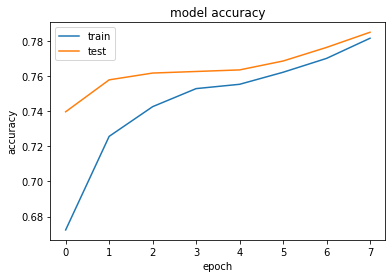

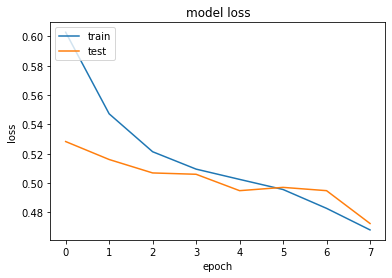

In [45]:
#importing library for plotting graph
import matplotlib.pyplot as plt

#Plotting Model accuracy on training and testing dataset with epochs
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#Plotting Model Loss on training and testing dataset with epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [46]:
#Predicting padded testing dataset
Y_pred=model1.predict(X_test_padded)

In [47]:
#Checking the shape of the Y_pred vector and the Y_test vector
Y_pred.shape,Y_test.shape

((3360, 1), (3360,))

In [48]:
#Making the shape of the Y_pred vector same as the Y_test vector
Y_pred=Y_pred.reshape(Y_pred.shape[0])

(array([649., 364., 253., 271., 221., 274., 230., 255., 333., 510.]),
 array([0.00424454, 0.10174619, 0.19924785, 0.2967495 , 0.39425117,
        0.4917528 , 0.5892545 , 0.68675613, 0.78425777, 0.88175946,
        0.9792611 ], dtype=float32),
 <a list of 10 Patch objects>)

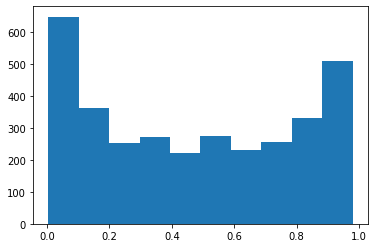

In [49]:
#Plotting histogram of Y_pred
plt.hist(Y_pred)

In [50]:
#Calculating cutoff for labels using Kolmogorov-Smirnov(KS)
cutoffs=np.linspace(0.01,0.99,99)
KS_all=[]
for cutoff in cutoffs:
    predicted=(Y_pred>cutoff).astype(int)    #Predicted value
    real=Y_test                                  #Real value

    TP=((predicted==1) & (real==1)).sum()        #True Positive
    TN=((predicted==0) & (real==0)).sum()        #True Negative
    FP=((predicted==1) & (real==0)).sum()        #False Positive
    FN=((predicted==0) & (real==1)).sum()        #False Negative
    
    P=TP+FN                                      #Positives(real)
    N=TN+FP                                      #Negatives(real)
    
    KS=(TP/P)-(FP/N)                             #KS value
    
    KS_all.append(KS)                            #KS values for all cutoffs

mycutoff1=cutoffs[KS_all==max(KS_all)][0]        #Cutoff with maximum KS value
print("KS-score =",max(KS_all),"  MyCutoff =",mycutoff1)

KS-score = 0.5699119380048111   MyCutoff = 0.51


In [51]:
predicted=(Y_pred>mycutoff1).astype(int)     #Predicted value
real=Y_test                                  #Real value
Precision_sum=0
Recall_sum=0

for i in range(len(classes1)):
  print("For class :",classes1[i])
  TP=((predicted==i) & (real==i)).sum()        #True Positive
  TN=((predicted!=i) & (real!=i)).sum()        #True Negative
  FP=((predicted==i) & (real!=i)).sum()        #False Positive
  FN=((predicted!=i) & (real==i)).sum()        #False Negative

  P=TP+FN                                      #Positives(real)
  N=TN+FP                                      #Negatives(real)

  Total=P+N                                    #Total tuples

  #Calculating all metrices
  Accuracy=(TP+TN)/Total
  Sensitivity=TP/P
  Specificity=TN/N
  Precision=TP/(TP+FP)
  Precision_sum+=Precision
  Recall=TP/P
  Recall_sum+=Recall
  KS=(TP/P)-(FP/N) 
  F1=2*Precision*Recall/(Precision+Recall)

  print("TP:",TP,"TN:",TN,"FP:",FP,"FN:",FN,"P:",P,"N:",N,"Total:",Total)
  print("Accuracy    =",Accuracy)
  print("Sensitivity =",Sensitivity)
  print("Specificity =",Specificity)
  print("Precision   =",Precision)
  print("Recall      =",Recall)
  print("KS          =",KS)
  print("F1          =",F1)
  print()

#Global
Precision=Precision_sum/len(classes1)
Recall=Recall_sum/len(classes1)
F1=2*Precision*Recall/(Precision+Recall)

print("Global Metrics:")
print("Accuracy    =",Accuracy)
print("Precision   =",Precision)
print("Recall      =",Recall)
print("KS          =",KS)
print("F1          =",F1)

For class : NOT
TP: 1446 TN: 1196 FP: 366 FN: 352 P: 1798 N: 1562 Total: 3360
Accuracy    = 0.7863095238095238
Sensitivity = 0.8042269187986651
Specificity = 0.765685019206146
Precision   = 0.7980132450331126
Recall      = 0.8042269187986651
KS          = 0.5699119380048111
F1          = 0.8011080332409972

For class : OFF
TP: 1196 TN: 1446 FP: 352 FN: 366 P: 1562 N: 1798 Total: 3360
Accuracy    = 0.7863095238095238
Sensitivity = 0.765685019206146
Specificity = 0.8042269187986651
Precision   = 0.772609819121447
Recall      = 0.765685019206146
KS          = 0.5699119380048111
F1          = 0.7691318327974276

Global Metrics:
Accuracy    = 0.7863095238095238
Precision   = 0.7853115320772798
Recall      = 0.7849559690024055
KS          = 0.5699119380048111
F1          = 0.7851337102839309


In [53]:
from sklearn.metrics import classification_report
print(classification_report(real,predicted,target_names=classes1))

              precision    recall  f1-score   support

         NOT       0.80      0.80      0.80      1798
         OFF       0.77      0.77      0.77      1562

    accuracy                           0.79      3360
   macro avg       0.79      0.78      0.79      3360
weighted avg       0.79      0.79      0.79      3360



In [54]:
!pip install mlxtend==0.17.0

     |████████████████████████████████| 1.3MB 6.0MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


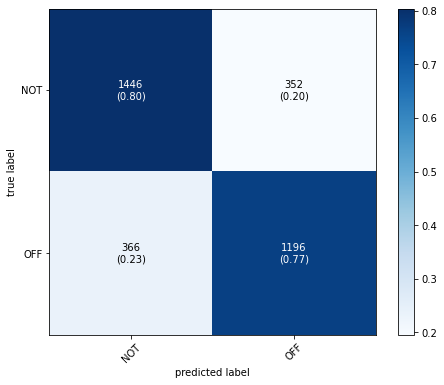

In [55]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib

mat=confusion_matrix(Y_test, predicted)
fig, ax = plot_confusion_matrix(conf_mat=mat,figsize=(8,6),colorbar=True,show_normed=True,class_names=classes1)
plt.show()

In [56]:
X_test[0],classes1[int(predicted[0])],classes1[Y_test[0]]

('user ugh love gamecocks stay safe come home us soon', 'NOT', 'NOT')

In [57]:
#Predicting tweets
instance = df['tweet'][9]
print(instance)

instance_seq = tokenizer1.texts_to_sequences([instance])

instance_padded = pad_sequences(instance_seq, padding='post', maxlen=maxlen)

pred=model1.predict(instance_padded)
print(pred)
classes1[int(pred[0,0]>mycutoff1)],df['subtask_a'][9]

user canada need another cuck already enough looneyleft liberals fking great country qproofs trudeaumustgo
[[0.9003587]]


('OFF', 'OFF')

**2nd** level classification starts here...

In [58]:
#Dataset import
df2=df.loc[df["subtask_b"].notnull()]
df2.reset_index(inplace=True,drop=True)

In [59]:
#Sample data
df2.head()

,tweet,subtask_a,subtask_b,subtask_c
0,user ask native americans take,OFF,UNT,NaN
1,user user go home drink user maga trump2020 url,OFF,TIN,IND
2,user someone shouldvetaken piece shit volcano,OFF,UNT,NaN
3,user liberals kookoo,OFF,TIN,OTH
4,user user oh noes tough shit,OFF,UNT,NaN


In [60]:
#Shape of the dataset
df2.shape

(4400, 4)

In [61]:
#Class counts
df2["subtask_b"].value_counts()

TIN    3876
UNT     524
Name: subtask_b, dtype: int64

In [62]:
#df2a represents the tweets with the targeted class
df2a=df2[df2["subtask_b"]=="TIN"]
#df2b represnts the tweets with the untargeted class
df2b=df2[df2["subtask_b"]=="UNT"]
df2b.head()

,tweet,subtask_a,subtask_b,subtask_c
0,user ask native americans take,OFF,UNT,NaN
2,user someone shouldvetaken piece shit volcano,OFF,UNT,NaN
4,user user oh noes tough shit,OFF,UNT,NaN
13,user user user refer hillary know tiresome ber...,OFF,UNT,NaN
34,user literally narrative par nazis punch antif...,OFF,UNT,NaN


In [63]:
#Upscaling
df2b=df2b.sample(n=int(0.9*df2a.shape[0]),replace=True,random_state=2)
df2=pd.concat([df2a,df2b],axis=0)
df2=df2.reset_index(drop=True)
df2.head()

,tweet,subtask_a,subtask_b,subtask_c
0,user user go home drink user maga trump2020 url,OFF,TIN,IND
1,user liberals kookoo,OFF,TIN,OTH
2,user literally talk laughing out loud mass sho...,OFF,TIN,GRP
3,user canada need another cuck already enough l...,OFF,TIN,IND
4,user lie corrupt traitor nobody want hear anym...,OFF,TIN,IND


In [64]:
#Input data for the level 2 classification
X=df2["tweet"]

In [65]:
#Y is the output class with value 0 if it is untargeted else 1
Y=df2['subtask_b'].apply(lambda x: 0 if x =='UNT' else 1)
#2 classes at level 2
classes2=["UNT","TIN"]
#Class count
(Y==0).sum(),(Y==1).sum()

(3488, 3876)

In [66]:
#Splitting the training and testing datset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [67]:
#Resetting the indices of the split dataset
X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)
Y_train=Y_train.reset_index(drop=True)

In [68]:
#Fitting tokenizer with training data
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(X_train)

#Texts converted to sequences
X_train_seq = tokenizer2.texts_to_sequences(X_train)
X_test_seq = tokenizer2.texts_to_sequences(X_test)

In [69]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer2.word_index) + 1

maxlen = 100

#Padding sequences to get same length sequences
X_train_padded = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test_padded = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

In [70]:
#Creating embedding matrix(vocabulory) for all the words in tokenizer
embedding_matrix = np.zeros((vocab_size, 200))
for word, index in tokenizer2.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [71]:
#Adding all the layers dropout, bidirectional lstm, dense, embedding layers to the sequential model
#Output layer has sigmoid function to classify into two labels.
model2 = Sequential()
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model2.add(embedding_layer)
model2.add(SpatialDropout1D(0.3))
model2.add(Bidirectional(LSTM(32,activation='tanh',return_sequences=True)))
model2.add(Dropout(0.3))
model2.add(Bidirectional(LSTM(32,activation='tanh',return_sequences=False)))
model2.add(Dropout(0.2))
model2.add(Dense(100,activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))

In [72]:
#Compiling the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [73]:
#Summary of the model
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          1532000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 64)           59648     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)              

In [74]:
#Training the model with training dataset and validating it on testing dataset
history = model2.fit(X_train_padded, Y_train, batch_size=64, epochs=8, verbose=1, validation_data=(X_test_padded,Y_test))
#Evaluating the testing dataset on the trained model
score = model2.evaluate(X_test_padded, Y_test, verbose=1)

Epoch 1/8
93/93 [==============================] - 27s 219ms/step - loss: 0.6823 - acc: 0.5432 - val_loss: 0.6392 - val_acc: 0.6429
Epoch 2/8
93/93 [==============================] - 19s 204ms/step - loss: 0.6331 - acc: 0.6558 - val_loss: 0.5909 - val_acc: 0.6823
Epoch 3/8
93/93 [==============================] - 19s 206ms/step - loss: 0.5903 - acc: 0.6953 - val_loss: 0.5669 - val_acc: 0.6999
Epoch 4/8
93/93 [==============================] - 19s 206ms/step - loss: 0.5750 - acc: 0.7032 - val_loss: 0.5302 - val_acc: 0.7427
Epoch 5/8
93/93 [==============================] - 19s 208ms/step - loss: 0.5252 - acc: 0.7349 - val_loss: 0.5008 - val_acc: 0.7583
Epoch 6/8
93/93 [==============================] - 19s 207ms/step - loss: 0.4796 - acc: 0.7706 - val_loss: 0.4225 - val_acc: 0.8147
Epoch 7/8
93/93 [==============================] - 19s 208ms/step - loss: 0.4347 - acc: 0.7989 - val_loss: 0.4372 - val_acc: 0.7997
Epoch 8/8
47/47 [==============================] - 2s 36ms/step - loss: 0.31

In [75]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.31757017970085144
Test Accuracy: 0.8737270832061768


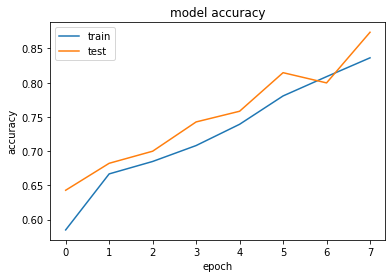

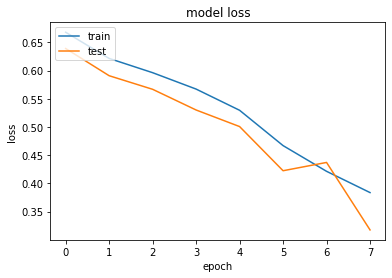

In [76]:
import matplotlib.pyplot as plt

#Plotting Model accuracy on training and testing dataset with epochs
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#Plotting Model Loss on training and testing dataset with epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [77]:
#Predicting padded testing dataset
Y_pred=model2.predict(X_test_padded)

In [78]:
#Checking the shape of the Y_pred vector and the Y_test vector
Y_pred.shape,Y_test.shape

((1473, 1), (1473,))

In [79]:
#Making the shape of the Y_pred vector same as the Y_test vector
Y_pred=Y_pred.reshape(Y_pred.shape[0])

(array([380., 158.,  92.,  64.,  40.,  41.,  63.,  55., 116., 464.]),
 array([0.02289703, 0.12043044, 0.21796384, 0.31549725, 0.41303065,
        0.510564  , 0.60809743, 0.70563084, 0.80316424, 0.90069765,
        0.99823105], dtype=float32),
 <a list of 10 Patch objects>)

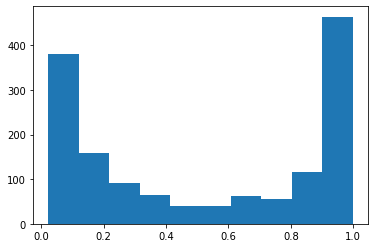

In [80]:
#Plotting the histogram of the test score
plt.hist(Y_pred)

In [81]:
#Calculating cutoff for labels using Kolmogorov-Smirnov(KS)
cutoffs=np.linspace(0.01,0.99,99)
KS_all=[]
for cutoff in cutoffs:
    predicted=(Y_pred>cutoff).astype(int)        #Predicted value
    real=Y_test                                  #Real value

    TP=((predicted==1) & (real==1)).sum()        #True Positive
    TN=((predicted==0) & (real==0)).sum()        #True Negative
    FP=((predicted==1) & (real==0)).sum()        #False Positive
    FN=((predicted==0) & (real==1)).sum()        #False Negative
    
    P=TP+FN                                      #Positives(real)
    N=TN+FP                                      #Negatives(real)
    
    KS=(TP/P)-(FP/N)                             #KS value
    
    KS_all.append(KS)                            #KS values for all cutoffs

mycutoff2=cutoffs[KS_all==max(KS_all)][0]        #Cutoff with maximum KS value
print("KS-score",max(KS_all),"MyCutoff=",mycutoff1)

KS-score 0.755473558388335 MyCutoff= 0.51


In [82]:
predicted=(Y_pred>mycutoff1).astype(int)      #Predicted value
real=Y_test                                   #Real value
Precision_sum=0
Recall_sum=0

for i in range(len(classes2)):
  print("For class :",classes2[i])
  TP=((predicted==i) & (real==i)).sum()        #True Positive
  TN=((predicted!=i) & (real!=i)).sum()        #True Negative
  FP=((predicted==i) & (real!=i)).sum()        #False Positive
  FN=((predicted!=i) & (real==i)).sum()        #False Negative

  P=TP+FN                                      #Positives(real)
  N=TN+FP                                      #Negatives(real)

  Total=P+N                                    #Total tuples

  #Calculating all metrices
  Accuracy=(TP+TN)/Total
  Sensitivity=TP/P
  Specificity=TN/N
  Precision=TP/(TP+FP)
  Precision_sum+=Precision
  Recall=TP/P
  Recall_sum+=Recall
  KS=(TP/P)-(FP/N) 
  F1=2*Precision*Recall/(Precision+Recall)

  print("TP:",TP,"TN:",TN,"FP:",FP,"FN:",FN,"P:",P,"N:",N,"Total:",Total)
  print("Accuracy    =",Accuracy)
  print("Sensitivity =",Sensitivity)
  print("Specificity =",Specificity)
  print("Precision   =",Precision)
  print("Recall      =",Recall)
  print("KS          =",KS)
  print("F1          =",F1)
  print()

#Global
Precision=Precision_sum/len(classes2)
Recall=Recall_sum/len(classes2)
F1=2*Precision*Recall/(Precision+Recall)

print("Global Metrics:")
print("Accuracy    =",Accuracy)
print("Precision   =",Precision)
print("Recall      =",Recall)
print("KS          =",KS)
print("F1          =",F1)

For class : UNT
TP: 611 TN: 674 FP: 123 FN: 65 P: 676 N: 797 Total: 1473
Accuracy    = 0.8723693143245078
Sensitivity = 0.9038461538461539
Specificity = 0.8456712672521958
Precision   = 0.832425068119891
Recall      = 0.9038461538461539
KS          = 0.7495174210983496
F1          = 0.8666666666666667

For class : TIN
TP: 674 TN: 611 FP: 65 FN: 123 P: 797 N: 676 Total: 1473
Accuracy    = 0.8723693143245078
Sensitivity = 0.8456712672521958
Specificity = 0.9038461538461539
Precision   = 0.912043301759134
Recall      = 0.8456712672521958
KS          = 0.7495174210983496
F1          = 0.8776041666666667

Global Metrics:
Accuracy    = 0.8723693143245078
Precision   = 0.8722341849395125
Recall      = 0.8747587105491748
KS          = 0.7495174210983496
F1          = 0.8734946236872537


In [83]:
print(classification_report(real,predicted,target_names=classes2))

              precision    recall  f1-score   support

         UNT       0.83      0.90      0.87       676
         TIN       0.91      0.85      0.88       797

    accuracy                           0.87      1473
   macro avg       0.87      0.87      0.87      1473
weighted avg       0.88      0.87      0.87      1473



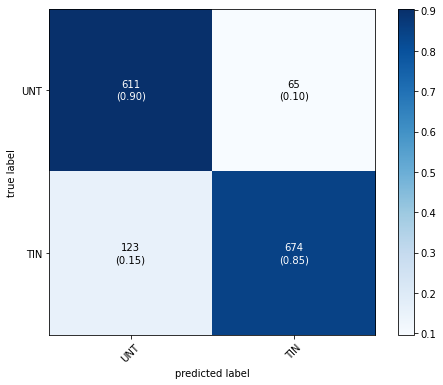

In [84]:
mat=confusion_matrix(Y_test, predicted)
fig, ax = plot_confusion_matrix(conf_mat=mat,figsize=(8,6),colorbar=True,show_normed=True,class_names=classes2)
plt.show()

In [85]:
#Predicting Tweets
instance = df['tweet'][9]
print(instance)

instance_seq = tokenizer2.texts_to_sequences([instance])

instance_padded = pad_sequences(instance_seq, padding='post', maxlen=maxlen)
#print(instance_padded.shape)
pred=model2.predict(instance_padded)
print(pred)
classes2[int(pred[0,0]>mycutoff1)],df['subtask_b'][9]

user canada need another cuck already enough looneyleft liberals fking great country qproofs trudeaumustgo
[[0.71714514]]


('TIN', 'TIN')

**3rd** level classification starts here

In [86]:
#Importing the datast with the 3rd subtask
df3=df.loc[df["subtask_c"].notnull()]
df3.reset_index(drop=True,inplace=True)

In [87]:
#Sample dataset
df3.head()

,tweet,subtask_a,subtask_b,subtask_c
0,user user go home drink user maga trump2020 url,OFF,TIN,IND
1,user liberals kookoo,OFF,TIN,OTH
2,user literally talk laughing out loud mass sho...,OFF,TIN,GRP
3,user canada need another cuck already enough l...,OFF,TIN,IND
4,user lie corrupt traitor nobody want hear anym...,OFF,TIN,IND


In [88]:
#Shape of the dataset
df3.shape

(3876, 4)

In [89]:
#Class counts
df3["subtask_c"].value_counts()

IND    2407
GRP    1074
OTH     395
Name: subtask_c, dtype: int64

In [90]:
#df3a,df3b,df3c represent the tweets with GRP target,IND target and OTH target respectively.
df3a=df3[df3["subtask_c"]=="GRP"]
df3b=df3[df3["subtask_c"]=="IND"]
df3c=df3[df3["subtask_c"]=="OTH"]

In [91]:
#Downscaling
df3a=df3a.sample(n=int(0.9*df3b.shape[0]),replace=True,random_state=2)
#Upscaling
df3c=df3c.sample(n=int(0.9*df3b.shape[0]),replace=True,random_state=2)
df3=pd.concat([df3a,df3b,df3c],axis=0)
df3=df3.reset_index(drop=True)
df3.head()

,tweet,subtask_a,subtask_b,subtask_c
0,user user zero evidence gaff job thing hijinx ...,OFF,TIN,GRP
1,user user user user user user liberals sensiti...,OFF,TIN,GRP
2,user dregs society isis antifa blm plan parent...,OFF,TIN,GRP
3,user censor user qanon merchandise really zazz...,OFF,TIN,GRP
4,user irony murder do illegal gun users gang me...,OFF,TIN,GRP


In [92]:
#Input tweets
X=df3["tweet"]

In [93]:
#Y represents the vector of 0,1,2
#0 represents OTH,1 represents IND and 2 represents GRP
Y = (df3["subtask_c"]=="IND").astype(int)
Y2 = (df3["subtask_c"]=="GRP").astype(int)*2
Y+=Y2

In [94]:
#Class counts
Y.value_counts()

1    2407
2    2166
0    2166
Name: subtask_c, dtype: int64

In [95]:
#Class vector
classes3=["OTH","IND","GRP"]

In [96]:
#Splitting the training and testing dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [97]:
#Resetting the indices of the split datasets
X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)
Y_train=Y_train.reset_index(drop=True)

In [98]:
#Fitting tokenizer with training data
tokenizer3 = Tokenizer()
tokenizer3.fit_on_texts(X_train)

#Text converted to sequences
X_train_seq = tokenizer3.texts_to_sequences(X_train)
X_test_seq = tokenizer3.texts_to_sequences(X_test)

In [99]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer3.word_index) + 1

maxlen = 100

#Padding sequences to get same length sequences
X_train_padded = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test_padded = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

In [100]:
#Creating embedding matrix(vocabulory) for all the words in tokenizer
embedding_matrix = np.zeros((vocab_size, 200))
for word, index in tokenizer3.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [101]:
#Adding all the layers dropout, bidirectional lstm, dense, embedding layers to the sequential model
#Output layer has sigmoid function to classify into two labels.
model3 = Sequential()
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model3.add(embedding_layer)
model3.add(SpatialDropout1D(0.4))
model3.add(Bidirectional(LSTM(32,activation='tanh',return_sequences=True)))
model3.add(Dropout(0.3))
model3.add(Bidirectional(LSTM(32,activation='tanh',return_sequences=False)))
model3.add(Dropout(0.2))
model3.add(Dense(100,activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(units=3, activation='softmax'))

In [102]:
#Compiling the model
model3.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [103]:
#Summary of the model
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          1446600   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 64)           59648     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [104]:
#Training the model with training dataset and validating it on testing dataset
history = model3.fit(X_train_padded, Y_train, batch_size=32, epochs=10, verbose=1,validation_data=(X_test_padded,Y_test))
#Evaluating the testing dataset on the trained model
score = model3.evaluate(X_test_padded, Y_test, verbose=1)

Epoch 1/10
169/169 [==============================] - 33s 155ms/step - loss: 1.0700 - sparse_categorical_accuracy: 0.4091 - val_loss: 0.9862 - val_sparse_categorical_accuracy: 0.5134
Epoch 2/10
169/169 [==============================] - 25s 148ms/step - loss: 0.9701 - sparse_categorical_accuracy: 0.5456 - val_loss: 0.9314 - val_sparse_categorical_accuracy: 0.5497
Epoch 3/10
169/169 [==============================] - 28s 164ms/step - loss: 0.9397 - sparse_categorical_accuracy: 0.5691 - val_loss: 0.8806 - val_sparse_categorical_accuracy: 0.5809
Epoch 4/10
169/169 [==============================] - 25s 149ms/step - loss: 0.9082 - sparse_categorical_accuracy: 0.5915 - val_loss: 0.8436 - val_sparse_categorical_accuracy: 0.6202
Epoch 5/10
169/169 [==============================] - 25s 149ms/step - loss: 0.8336 - sparse_categorical_accuracy: 0.6491 - val_loss: 0.7787 - val_sparse_categorical_accuracy: 0.6855
Epoch 6/10
169/169 [==============================] - 25s 151ms/step - loss: 0.7901 -

In [105]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.5265539288520813
Test Accuracy: 0.8019287586212158


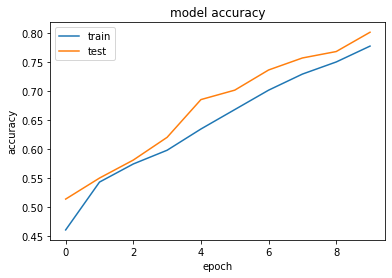

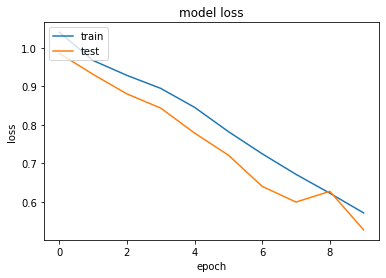

In [106]:
import matplotlib.pyplot as plt

plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])

#Plotting Model accuracy on training and testing dataset with epochs
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#Plotting Model Loss on training and testing dataset with epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [107]:
#Predicting padded testing dataset
Y_pred=model3.predict(X_test_padded)

In [108]:
#Checking the shape of the Y_pred vector and the Y_test vector
Y_pred.shape,Y_test.shape

((1348, 3), (1348,))

In [109]:
predicted=Y_pred.argmax(axis=1)              #Predicted value
real=Y_test                                  #Real value
Precision_sum=0
Recall_sum=0
Accuracy_sum=0

for i in range(len(classes3)):
  print("For class :",classes3[i])
  TP=((predicted==i) & (real==i)).sum()        #True Positive
  TN=((predicted!=i) & (real!=i)).sum()        #True Negative
  FP=((predicted==i) & (real!=i)).sum()        #False Positive
  FN=((predicted!=i) & (real==i)).sum()        #False Negative

  P=TP+FN                                      #Positives(real)
  N=TN+FP                                      #Negatives(real)

  Total=P+N                                    #Total tuples

  #Calculating all metrices
  Accuracy=(TP+TN)/Total
  Accuracy_sum+=Accuracy
  Sensitivity=TP/P
  Specificity=TN/N
  Precision=TP/(TP+FP)
  Precision_sum+=Precision
  Recall=TP/P
  Recall_sum+=Recall
  KS=(TP/P)-(FP/N) 
  F1=2*Precision*Recall/(Precision+Recall)

  print("TP:",TP,"TN:",TN,"FP:",FP,"FN:",FN,"P:",P,"N:",N,"Total:",Total)
  print("Accuracy    =",Accuracy)
  print("Sensitivity =",Sensitivity)
  print("Specificity =",Specificity)
  print("Precision   =",Precision)
  print("Recall      =",Recall)
  print("KS          =",KS)
  print("F1          =",F1)
  print()

#Global
Precision=Precision_sum/len(classes3)
Recall=Recall_sum/len(classes3)
Accuracy=Accuracy_sum/len(classes3)
F1=2*Precision*Recall/(Precision+Recall)

print("Global Metrics:")
print("Accuracy    =",Accuracy)
print("Precision   =",Precision)
print("Recall      =",Recall)
print("F1          =",F1)

For class : OTH
TP: 399 TN: 806 FP: 102 FN: 41 P: 440 N: 908 Total: 1348
Accuracy    = 0.8939169139465876
Sensitivity = 0.9068181818181819
Specificity = 0.8876651982378855
Precision   = 0.7964071856287425
Recall      = 0.9068181818181819
KS          = 0.7944833800560673
F1          = 0.8480340063761956

For class : IND
TP: 313 TN: 841 FP: 53 FN: 141 P: 454 N: 894 Total: 1348
Accuracy    = 0.8560830860534124
Sensitivity = 0.6894273127753304
Specificity = 0.9407158836689038
Precision   = 0.855191256830601
Recall      = 0.6894273127753304
KS          = 0.6301431964442342
F1          = 0.7634146341463415

For class : GRP
TP: 369 TN: 782 FP: 112 FN: 85 P: 454 N: 894 Total: 1348
Accuracy    = 0.8538575667655787
Sensitivity = 0.8127753303964758
Specificity = 0.8747203579418344
Precision   = 0.7671517671517671
Recall      = 0.8127753303964758
KS          = 0.6874956883383102
F1          = 0.7893048128342246

Global Metrics:
Accuracy    = 0.8679525222551928
Precision   = 0.8062500698703703
Reca

In [110]:
print(classification_report(real,predicted,target_names=classes3))

              precision    recall  f1-score   support

         OTH       0.80      0.91      0.85       440
         IND       0.86      0.69      0.76       454
         GRP       0.77      0.81      0.79       454

    accuracy                           0.80      1348
   macro avg       0.81      0.80      0.80      1348
weighted avg       0.81      0.80      0.80      1348



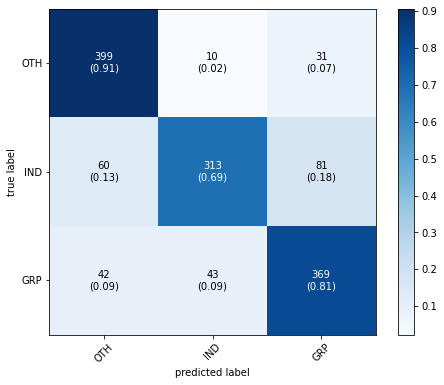

In [111]:
mat=confusion_matrix(Y_test, predicted)
fig, ax = plot_confusion_matrix(conf_mat=mat,figsize=(8,6),colorbar=True,show_normed=True,class_names=classes3)
plt.show()

In [114]:
#Predicting Tweets
instance = df['tweet'][15]
print(instance)

instance_seq = tokenizer3.texts_to_sequences([instance])

instance_padded = pad_sequences(instance_seq, padding='post', maxlen=maxlen)
print(instance_padded.shape)
pred=model3.predict(instance_padded)
print(pred)
classes3[np.argmax(pred)],df['subtask_c'][1]

user also king taste
(1, 100)
[[0.00536417 0.982832   0.01180376]]


('IND', 'IND')

Combined testing at all the 3 levels

In [115]:
#Testing model with 3-level classification
def testing_model(instance,tokenizer,model):
  instance_seq = tokenizer.texts_to_sequences([instance])
  instance_padded = pad_sequences(instance_seq, padding='post', maxlen=maxlen)

  return model.predict(instance_padded)

In [116]:
#Method to test an instance at all the 3 levels of classification.
def testing(instance):
  print(instance)
  #Level 1 prediction
  pred=testing_model(instance,tokenizer1,model1)
  print("level1:",pred)
  if pred[0,0]<=mycutoff1:
    print(classes1[0])
  else:
    print(classes1[1])
    #Level 2 prediction
    pred=testing_model(instance,tokenizer2,model2)
    print("level2:",pred)
    if pred[0,0]<=mycutoff2:
      print(classes2[0])
    else:
      print(classes2[1])
      #Level 3 prediction
      pred=testing_model(instance,tokenizer3,model3)
      print("level3:",pred[0])
      k=np.argmax(pred)
      print(classes3[k])
    

In [118]:
#Testing for an instance at index 9
testing(df['tweet'][9])

user canada need another cuck already enough looneyleft liberals fking great country qproofs trudeaumustgo
level1: [[0.9003587]]
OFF
level2: [[0.71714514]]
TIN
level3: [0.3707404  0.10920954 0.5200501 ]
GRP


In [119]:
#Output of the instance at index 9
df['subtask_a'][9],df['subtask_b'][9],df['subtask_c'][9]

('OFF', 'TIN', 'IND')

In [120]:
#Testing custom input data
testing('I am a good boy')

I am a good boy
level1: [[0.19248605]]
NOT


In [121]:
#Testing custom input data
testing('Bad people are very bad')

Bad people are very bad
level1: [[0.8530641]]
OFF
level2: [[0.8052219]]
TIN
level3: [0.06724953 0.6967489  0.23600161]
IND
